In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

MSE:  2.071
R2:   0.955


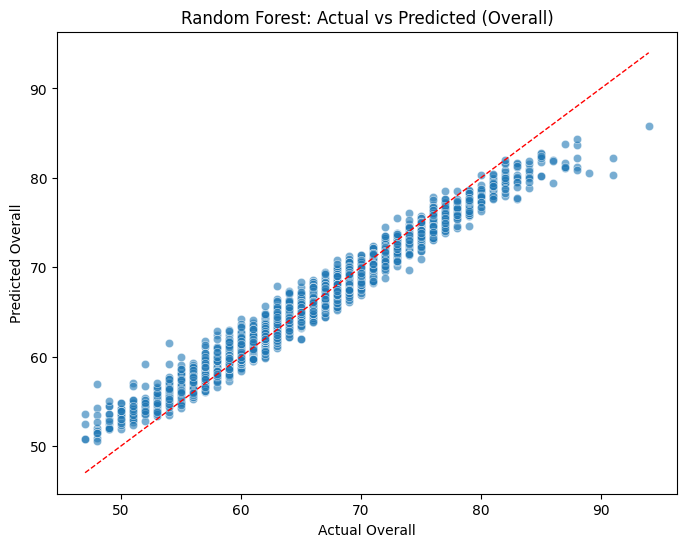

In [3]:
# Load dataset
data = pd.read_csv('../datasets/cleaned.csv')

# Target
target_col = 'Overall'
y = data[target_col]

# Drop rows with missing target
mask = y.notna()
data = data[mask].copy()
y = y[mask]

# Feature set: drop IDs/names/dates + market vars to avoid leakage
drop_cols = [
    'ID', 'Name', 'Joined', 'Contract Valid Until',
    'Wage', 'Value', 'Release Clause',
    target_col
]
X = data.drop(columns=[c for c in drop_cols if c in data.columns])

# Split by dtype
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.columns.difference(categorical_cols)

# Preprocessing: impute numeric/categorical, then one-hot encode categoricals
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # use sparse_output=False if warned
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
    ],
    remainder='drop'
)

# Random Forest pipeline
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('rf', rf)
])

# Modest hyperparameter grid (expand if needed)
param_grid = {
    'rf__n_estimators': [200, 500],
    'rf__max_depth': [None, 20, 40],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 0.5],  # 'sqrt' is common for RF; 0.5 means 50% features
}

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Quick random forest regression
rf_fast = Pipeline(steps=[
    ('preprocess', preprocess),
    ('rf', RandomForestRegressor(
        n_estimators=200, max_depth=None, max_features='sqrt',
        min_samples_split=2, min_samples_leaf=1,
        random_state=42, n_jobs=-1, max_samples=0.7  # subsample for speed
    ))
])
rf_fast.fit(X_train, y_train)
y_pred = rf_fast.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE:  {mse:.3f}")
print(f"R2:   {r2:.3f}")

# Plot predictions vs actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Actual Overall")
plt.ylabel("Predicted Overall")
plt.title("Random Forest: Actual vs Predicted (Overall)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=1)
plt.show()